# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Write-a-SNE-function" data-toc-modified-id="Write-a-SNE-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Write a SNE function</a></div><div class="lev1 toc-item"><a href="#Fake-data" data-toc-modified-id="Fake-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fake data</a></div><div class="lev2 toc-item"><a href="#Make-P" data-toc-modified-id="Make-P-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Make P</a></div><div class="lev1 toc-item"><a href="#Calculate-the-gradient-of-the-KL-divergence" data-toc-modified-id="Calculate-the-gradient-of-the-KL-divergence-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculate the gradient of the KL divergence</a></div>

# A tutorial on t-SNE

In this tutorial, I will aim to implement a straightforward version of the Stochastic Neighbor Embedding (SNE) and Student-t Stochastic Neighbor Embedding (t-SNE) algorithms. In this notebook, I will pay special attention to the technical details for how to implement the algorithm in a vectorized fashion. I will also review the mathematic in detail, ending with a short discussion on why I believe t-SNE is, fundamentally, not a clustering algorithm, and is only useful for plotting purposes. 

As always, we begin by importing our useful libraries.

In [2]:
import pandas as pd
import numba
import numpy as np
import scipy
from sklearn import manifold
from sklearn import decomposition
import tsne_functions as tsf

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

# The SNE algorithm

The stochastic neighbor embedding algorithm minimizes the KL divergence between a set of points, $X \in \mathbb{R}^n$, and a reduced map of these points, $Y \in \mathbb{R}^d$, where usually $d=2$. The goal will be to project the points in $X$ to coordinates in $Y$ in a way that minimizes a cost function, known as the Kullback-Leibler (KL) divergence between the original coordinates and the reduced coordinates. To perform this projection, we model the interactions between points as Gaussian kernels. In other words, the probability that node $j$ is a neighbor of $i$ in the coordinates $M$ ($M$ can be $X$ or $Y$) as:

$$
p(j|i, M) = \frac{\exp(|M_i - M_j|^2/2\sigma_{M, i}^2)}{\sum_{k \neq i} \exp(|M_i - M_j|^2/2\sigma_{M, i}^2},\\
$$

where $M_k$ are vectors in $X$ or $Y$. **Additionally  when $M$ is $Y$, $\sigma_{Y, i} = 1/\sqrt{2}$ for simplicity**. For this reason, I refer to $\sigma_{X, i}$ as $\sigma_i$.

The above function can be interpreted as saying that $j$ is likely to be considered a neighbor by $i$ if $j$ is close to $i$ in the Euclidean space, and $j$ is more likely to be considered a neighbor by $i$ if $i$ is relatively lonely (no other nodes $k$ are considered neighbors by $i$). In SNE, we consider this statement (including the mathematical details) to be exactly the same for points in $\mathbb{R}^n$ or $\mathbb{R}^d$. Thus, minimizing the KL divergence amounts to stating that points that are relatively close in high-dimensional space should remain relatively close in low-dimensional space. Specifically, we would like the probability of $j$ being considered a neighbor by $i$ to remain similar in both coordinate systems. **Notice that this probability, $p(j|i)$ is not symmetric: $p(j~|i) \neq p(i~|j)$ in general**. The lack of symmetry means that distances in the low-dimensional representation $Y$  are not indicative of similarity or "distance" from each other, because the two nodes do not agree on a single number. 

## Perplexity sets the distance scale for calling someone your neighbor 

A particular point that I'd like focus on are the $\sigma_{X, i}$ and $\sigma_{Y,i}$ values. First of all, the $\sigma_{X, i}$ values are unknown in the SNE algorithm, and there is no procedure to identify an "optimal" $\sigma_{X,i}$; rather, the user sets the "average" value of this parameter for all points and a set $\{\sigma_{X, i}\}$ is found that satisfies the user-specified condition. This "average value" is a function of the perplexity parameter that SNE and t-SNE algorithms require as input. 

These $\sigma_{X, i}$ values matter because they set the distance scale on which a node will consider other nodes to be its neighbors (i.e., nodes become greedier the larger the perplexity is set, and lonelier if it is smaller) in the high-dimensional coordinate system $X$. 

In theory, there should also be a complementary set $\{\sigma_{Y, i}\}$ in the low-dimensional space, $Y$. However, for simplicity, the choice is often made to set all these parameters to $1/\sqrt{2}$. This ammounts to saying that in the low-dimensional space, the nodes are all equally greedy. 

There are two problematic aspects for this methodology. First of all, it may well be the case that there is an optimal $\sigma_{X, i}$ for a given data point, and it should be chosen carefully. Secondly, if we go to the trouble of specifying that nodes in high-dimensional space have varied greediness, why not insist that they have varied greediness in low-dimensional space as well? My best guess is that regularizing the perplexity parameter to a single value in low-dimensional space  probably helps the algorithm generate clusters that are more or less evenly dense throughout.



## t-SNE and SNE differ in two ways

The first difference between SNE and t-SNE is that t-SNE symmetrizes the probability distribution, $p_ij = 1/2(p(i~|j) + p(j~|i))$. The meaning of this new variable, though represented by $p$ is not entirely clear to me. It is specifically not the probability that both $i$ and $j$ simultaneously consider the other to be neighbors. It's a probability distribution in the sense that it adds to 1, but its meaning is not clear to me.

The second difference between these two algorithms is that whereas conventional SNE uses a Gaussian model to model the low-dimensional neighborhoods, t-SNE modifies this by using a Student-t distribution with a single degree of freedom:

$$
q_ij = \frac{(1 + |y_i - y_j|^2)^{-1}}{\sum_{k\neq l}(1 + |y_k - y_l|^2)^{-1}}
$$

A significant reason to use the Student-t is that the gradient descent becomes much, much easier. There also exists a claim that the Student-t distribution will, in general, push dissimilar points farther apart and push similar points closer together, leading to better clustering. I should point out that the cut-off point for the dissimilarity probably depends strongly on the perplexity, and for large enough perplexity values the algorithm might actually do the inverse (push similar points apart, and dissimilar points closer together).

# SNE and t-SNE minimize the Kullback Leibler divergence between the embedding and the data

Throughout the text, I have been hinting at the fact that we will make the nodes "see" the same neighbors in the reduced space as in the original space. The way to do this naturally is by the Kullback-Leibler (KL) divergence, which specifies the information that would be lost by replacing a probability distribution, $p$, by another, usually simpler, distribution, $q$. Since these are formally machine-learning algorithms, the KL function is usually called a Cost function:

$$
C = KL(X, Y) = \sum_{ij} p(j~|i, X) \log_2{p(j~|i, X)/p(j~|i, Y)}
$$

We can minimize the KL divergence by finding the gradient of this function with respect to $Y$. The gradient for SNE has a surprisingly simple form:
$$
\frac{dC}{dy_i} = \sum_j [p(j~|i, X) + p(i~|j, X) - p(j~|i, Y) - p(i~|j, Y)](y_i - y_j).
$$

The gradient for t-SNE is also simple:
$$
\frac{dC}{dy_i} = \sum_j [p_{ij} - q_{ij}](y_i - y_j)(1 + |y_i - y_j|^2)^{-1}
$$


In this Notebook, I would like to implement a basic strategy for gradient descent of the SNE function for a given dataset, $X$.

I will optimize $\sigma$ using a binary search method which I grabbed from Laurens van der Maaten's [original t-SNE python code](https://lvdmaaten.github.io/tsne/). I have modified that method, `x2p`, so that it takes in a function `Hbeta` and returns a Gaussian Kernel method.


Throughout this code, $P(j~|i, M)$ will be referred to as a matrix $P_{ij}(M)$.

Recall the information entropy equation is:
$$
I(i) \propto -\sum_{j} p(j~|i) \log p(j~|i, X).
$$

Plugging in and expanding, setting $|y_i - y_j|^2 = D_{ij}$:
$$
I(i) = -\sum_{j} p(j~|i) (-\frac{D_{ij}}{2\sigma_i^2} - \log \sum_{k\neq i} p(k~|i))
$$

This can be further simplified, letting $1/2\sigma_i^2 = \beta$ and $\sum_{k\neq i} p(k~|i)) = Z$:
$$
I(i) = \beta\sum_{j} p(j~|i) D_{ij} +  \log Z \sum_{j} \frac{\exp{(-\beta D_{ij})}}{Z}
$$

The last term of this equation is devilishly simple:
$$
\log (Z) \sum_{j} \frac{\exp{(-\beta D_{ij})}}{Z} = \log (Z) \sum_{k\neq i} \frac{\exp{(-\beta D_{ik})}}{Z} =   \frac{Z}{Z} \log(Z) = 1\log{Z}
$$

I changed the indices for visual contrast. Therefore, we can easily calculate the information entropy of node $i$. All we need to do is take the **element-wise** product ($\times$) of $P$ and $D$, sum across the columns and multiply the product by $\beta$, then add the normalization factor for $P$ and we are done:
$$
I(i) = \beta \sum_{j} \cdot P_{ij}\times D_{ij} + \log Z
$$


In [3]:
def Hbeta(D=np.array([]), beta=1.0):
    """Compute P(j|i, X) for row i."""
    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    # P does not have a P_ii entry, so we are free to do:
    sumP = P.sum()
    logZ = np.log(sumP)
    H =  beta * np.sum(D * P) / sumP + logZ
    P = P / sumP
    return H, P

The function above has written the argument $|y_i - y_j|^2$ as $D$. Next, we need to figure out what $D$ is. Expanding the square, it is clear that the argument can be expressed in terms of $y_i$ and $y_j$.
$$
D_{ij} = |y_i - y_j|^2 = ||y_i - y_j||\cdot ||y_i - y_j|| = ||y_i||^2 + ||y_j||2 - 2y_i^Ty_j
$$

For a matrix $Y$ containing $y_1,\ldots,y_i, y_j, \ldots, y_n$ in $n$ columns of length $d$, we can simultaneously calculate the dot product of all vectors as $Y^T\cdot Y$. The result is a matrix of shape $n\times n$. 

**Note: I prefer to work with row vectors, so the matrix we need is $Y\cdot Y^T$ instead and $Y$ is $n\times d$.

The scale of each vector is simply $\sum_i y_i^2$. To do this for every $y_i$ simultaneously, we will need to take our matrix of row vectors, square each element, and sum along the rows: $\sum_i Y_i^2$.

It's easy enough to construct a temporary matrix $T$ using the two concepts above: $^{nn}T = -2(Y\cdot Y^T) ++ \sum_i Y_i^2$, where I have used the presuperscripts to denote the dimensions of $T$, and a double $+$ sign to denote element-wise addition. However, this matrix is incomplete, since we have not added $y_j$. 

To finish the calculation, I point out two important details. First, the $D = D^T$, since the length of the difference vector, $|y_i - y_j|$ doesn't change if the indices are switched around. Second, our temporary matrix $T$ *is also symmetric*. Functionally, what this means is that $T_{ij} = T_{ji}$. Since $T_{ij} = |y_i||^2  - 2y_i^Ty_j$, transposing $T$ has the effect that:

$$
T_{ji} = - 2y_j^Ty_i ++ |y_j||^2.
$$

In other words, although we thought we had added $|y_i|^2$ to $T$, we might as well have added $|y_j|^2$. We can finish the calculation by adding $|y_i|^2$ again:

$$
D = T^T ++ |y_i|^2
$$

I have coded this up in the matrix `make_D(X)`:

In [4]:
def make_D(data):
    """
    Calculates the norm of the difference of row vectors encoded in a
    matrix ``data`` by a smart linear algebra approach.
    
    Params:
    data -- matrix containing row vectors of observations
    
    Output:
    D -- the matrix containing ||y_i - y_j||^2.
    """    
    # make x_j2 = \sum_j x_ij^2
    x_j2 = np.sum(np.square(data), 1)
    # calculate x_j^T x_i
    dotprod = -2 * np.dot(data, data.T)
    # add the two vectors
    T = np.add(dotprod, x_j2)
    # transpose and add again
    # completes the square
    D = np.add(T.T, x_j2)
    # make sure nothing is below 0
    # (shouldn't be, but underflow is a killer)
    D = np.maximum(D, 0)
    return D

If we just want to do SNE, then the matrix calculated by the `x2p` function is sufficient. If we want to do t-SNE, though, we need a symmetric function that is $P + P^T$ and renormalized. Let's build a feeder function for that too. We will use it later.

In [4]:
def which_sne(P, sne=True):
    """
    If sne is true, return the matrix P as it was input; otherwise, return
    the sum of P and its transpose, divided by the sum of the matrix elements.
    """
    if sne:
        return P
    else:
        P = P + P.T
        P = P/P.sum()
        # underflow safety:
        P = np.maximum(P, 10**-12)
        return P

# Fake data

Next, I will draw data from four different distributions. We will perform PCA on this data (and plot the PCA) and then feed the PCA transformed data into our t-SNE function.

In [13]:
# Choose how many dimensions to measure in
dims = 100

# define a random direction to go in
g1 = np.random.normal(10, 2, dims)
g2 = np.random.normal(9.99, 2, dims)
g3 = np.random.normal(10, 3, dims)
g4 = np.random.normal(10, 4, dims)

# place them into a multidimensional array
mus = np.array([g1, g2, g3, g4])

# make sure everything is positive
mus = np.abs(mus)

# generate data points, complete with random errors:
# number of datapoints
measurements = 500
# initialize matrix
X = np.zeros((measurements, dims))
# initialize a cluster array
cluster = np.zeros(measurements)

# generate each point
for i in np.arange(measurements):
    # choose which cluster the measurement belongs to
    choice = np.random.choice(len(mus), 1)
    # Figure out how noisy the measurement is by picking
    # the noise from a half-gaussian distribution
    sigma = np.abs(np.random.normal(0, 1, dims))
    # generate the data by simulating a gaussian process
    sample = np.random.normal(mus[choice], sigma)
    # set anything below 0 to zero
    sample[sample < 0] = 0
    # assign the vector to the matrix row
    X[i, :] = sample
    # keep track of the cluster
    cluster[i] = choice

# normalize cells by counts
X = X/X.sum(axis=1).reshape(X.shape[0], 1)*10**3

In [23]:
# set to mean = 0 and std = 0
normX = (X - X.mean(axis=0))/X.std(axis=0)

# perform Principal Component Analysis
PCA = decomposition.PCA(10)
pcaX = PCA.fit_transform(normX)

Text(0,0.5,'PC2')

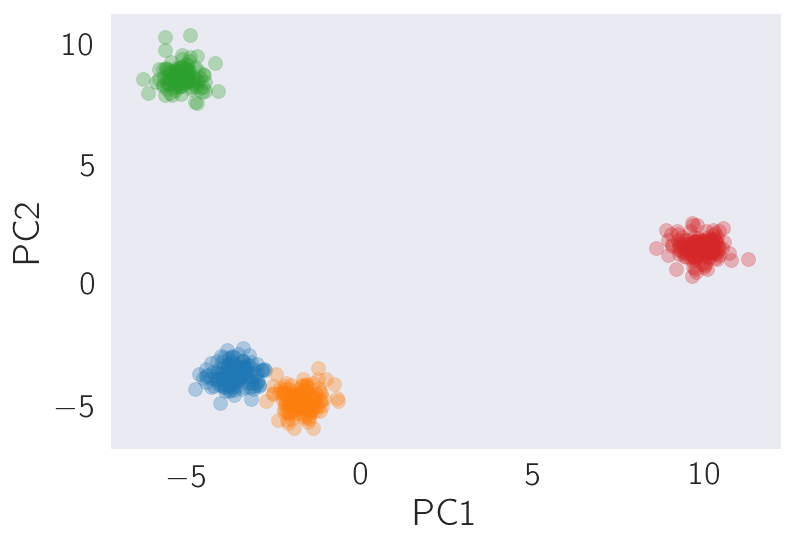

In [21]:
def plot_clusters(coords, n_clusters=4, jitter=0, colorV=np.array([]), ax=None, **kwargs):
    """
    Given a set of 2D coordinates, plot them in a single axes.
    Params:
    -------
    coords - 2D coordinates
    n_clusters -- number of clusters
    jitter -- add jitter to points
    colorV -- coloring for each cluster
    ax -- provide an axis to plot into
    **kwargs -- arguments for the ax.scatter function
    
    Output:
    ------
    ax - a matplotlib axis
    """
    if not ax:
        fig, ax = plt.subplots()
    
    # go through each cluster
    for i in np.arange(n_clusters):
        # select the points in cluster i
        x = coords[cluster == i, 0]
        y = coords[cluster == i, 1]
        
        # if necessary, add jitter
        if jitter:
            x += np.random.normal(0, jitter, len(x))
            y += np.random.normal(0, jitter, len(x))
        
        # color the points according to the cluster color, or 
        # just go with the default
        if len(colorV):
            color = colorV[cluster == i]
            ax.scatter(x, y, label='Cluster {0}'.format(i), c=color, **kwargs)
        else:
            ax.scatter(x, y, label='Cluster {0}'.format(i), **kwargs)
    
    # return
    if not ax:
        return fig, ax
    else:
        return None, ax

# plot
fig, ax = plot_clusters(pcaX, alpha=0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')    

## Make the matrix of probabilities, $P$

Using the code we implemented above, let's calculate the matrix of probabilities $P$ for a perplexity value of 30 (the default value for `x2p`).

In [19]:
P = tsf.x2p(Hbeta, make_D, pcaX)

Computing pairwise distances...
Computing P-values for point 0 of 500...
126 points failed to converge
Mean value of sigma: 3.2


# Calculate the gradient of the KL divergence

To calculate the gradient of the KL divergence, we will need:

$\{x_i\}$: The data coordinates in high-dimensional space
$\{y_i\}$: The data coordinates in low-dimensional space
$P_{i, X}$: The matrix of neighbor densities in high-dimensional space
$P_{i, Y}$: More commonly referred to as $Q$, the matrix of neighbor densities in low-dimensional space

We have almost everything we need. Below is a function I wrote to write the Q-matrix for SNE or t-SNE:

In [20]:
def make_Q(Dy, sne=True):
    """
    Calculates the Q matrix for SNE or t-SNE
    
    Params:
    -------
    Dy: A matrix of distances |y_i - y_j|^2
    sne: Whether to return a SNE Q matrix or a t-SNE Q matrix
    
    Output:
    Q: A SNE or t-SNE Q matrix
    """
    if sne:
        Q = np.exp(-Dy)
        np.fill_diagonal(Q, 0)
        Q = Q/np.exp(-Dy).sum(axis=0)[:, np.newaxis]
        Q = np.maximum(Q, 1e-12)
        return Q, None
    else:
        numerator = 1/(1 + (Dy))
        Q = numerator/np.sum(numerator)
        Q = np.maximum(Q, 1e-12)
        return Q, numerator

## Gradient function:
And below is a function to calculate the gradients in the case of SNE or t-SNE.

The gradient of the KL divergence in SNE is:
$$
\frac{dC}{dY_i} \propto \sum_j [(p(j~|i) + p(i~|j) - q(j~|i) - q(i~|j)] [y_i - y_j]
$$

The gradient of the KL divergence in t-SNE is:
$$
\frac{dC}{dY_i} \propto \sum_j [(p_{ji}  - q_{ji}] [y_i - y_j][1 + |y_i + y_j|^2]^{-1}
$$



In [21]:
def gradient(Y, P, Q, sne=True, numerator=None):
    """
    Calculate a gradient for SNE or t-SNE.
    
    Params:
    Y:
    P:
    Q:
    sne:
    numerator:
    
    Output:
    gradY
    """
    gradY = np.zeros((Y.shape))
    if sne:        
        for i in np.arange(Y.shape[0]):
            diff = P - Q + (P - Q).T  # symmetric
            diffi = np.tile(diff[:, i], (Y.shape[1], 1)).T
            dY = Y[i, :] - Y
            gradY[i, :] = 2*np.sum(np.multiply(diffi, dY), axis=0)
        return gradY
    else:
        for i in np.arange(Y.shape[0]):
            diff = P - Q  # symmetric
            diff = np.multiply(diff, numerator)  # symmetric
            diffi = np.tile(diff[:, i], (Y.shape[1], 1)).T
            dY = (Y[i, :] - Y)
            gradY[i, :] = 4*np.sum(diffi * dY, 0)
        return gradY

In [22]:
def run(Y, P, sne=True, max_iters=100, learn=500):
    """
    Performs a gradient descent for sne or t-sne.
    """
    jitter = np.random.uniform(0, 10**-2, max_iters-10)
    
    P = 4*P  # exaggerate
    for i in np.arange(max_iters):
        if i == 20:
            P = P/4

        Dy = make_D(Y)
        Q, numerator = make_Q(Dy, sne)
        gradY = gradient(Y, P, Q, gradY, sne, numerator)

        Y -= learn*gradY
        if i < 10:
            Y += np.random.normal(0, 2, Y.shape)
        else:
            Y += np.random.normal(0, jitter[i - 10], Y.shape)
        Y -= Y.mean(axis=0)[np.newaxis, :]

        if (np.isnan(Y)).any():
            raise ValueError('Y exploded')

        if i%10 == 0:
            C = np.sum(P*np.log(P/Q))
            print("Iteration %d: error is %f" % (i, C))
    return Y

# Running t-SNE

I will run only t-SNE here, since SNE is a bit trickier. 

In [23]:
P = tsf.x2p(Hbeta, make_D, pcaX)
P = which_sne(P, False)
Y = np.random.randn(X.shape[0], 2)
Y = run(Y, P, sne=False, learn=500)

Computing pairwise distances...
Computing P-values for point 0 of 500...
126 points failed to converge
Mean value of sigma: 3.2
Iteration 0: error is 15.824437
Iteration 10: error is 16.873087
Iteration 20: error is 2.626498
Iteration 30: error is 1.035982
Iteration 40: error is 0.952388
Iteration 50: error is 0.916863
Iteration 60: error is 0.891386
Iteration 70: error is 0.873496
Iteration 80: error is 0.856565
Iteration 90: error is 0.846215


The points cluster nicely!

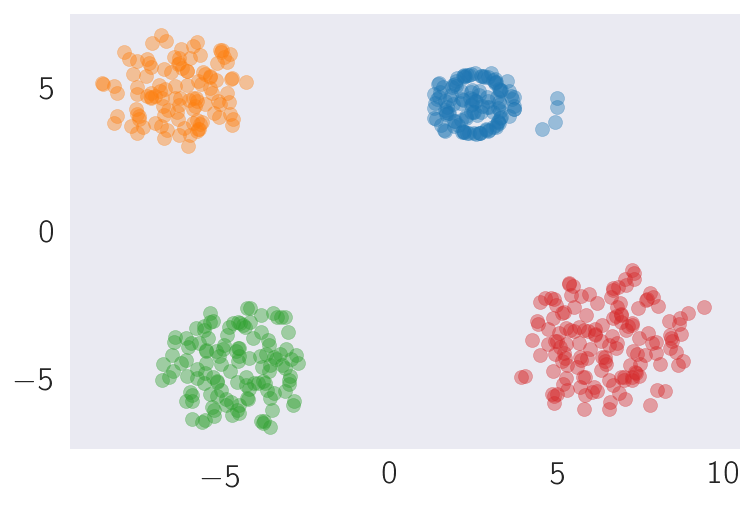

In [57]:
plot_clusters(Y, alpha=0.4)

# Coloring the points with NMF weightings

One thing people like to do is to generate the t-SNE plots and calculate NMF decomposition for the number of clusters they observe. Then, we can color the clusters by the extent to which each point belongs in a given cluster.

In [29]:
# calculate the NMF for the data, standardized to have a variance of 1
# since NMF only works on positive data, don't set the mean to 0
NMF = decomposition.NMF(4)
# extract point x cluster map
W = NMF.fit_transform(X/X.std(axis=0))
# extract cluster x gene map
H = NMF.components_

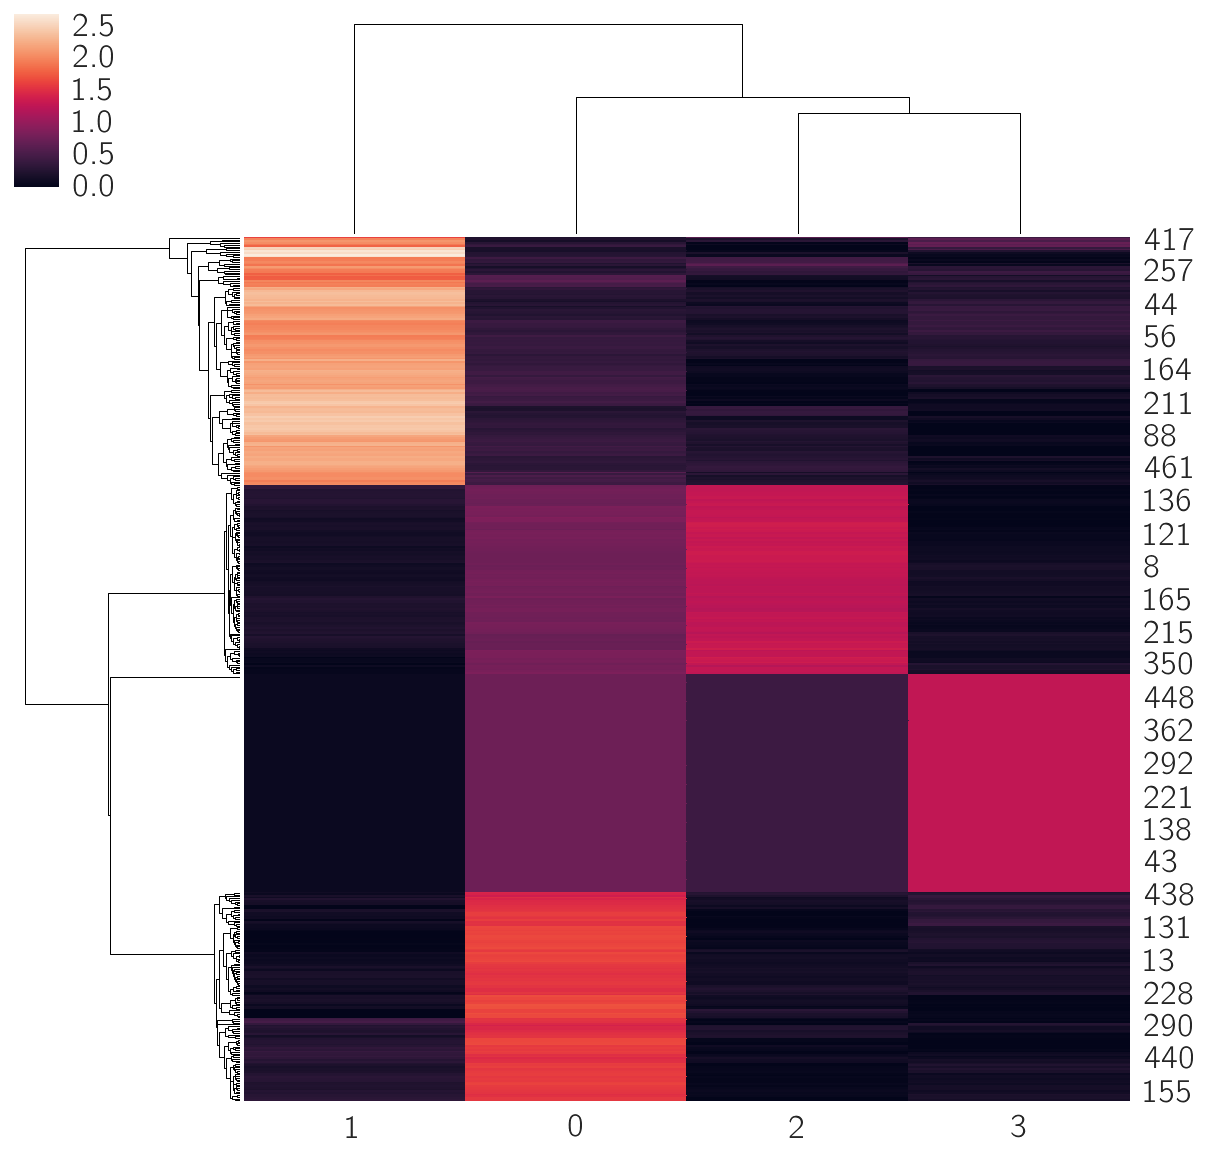

In [94]:
sns.clustermap(W)

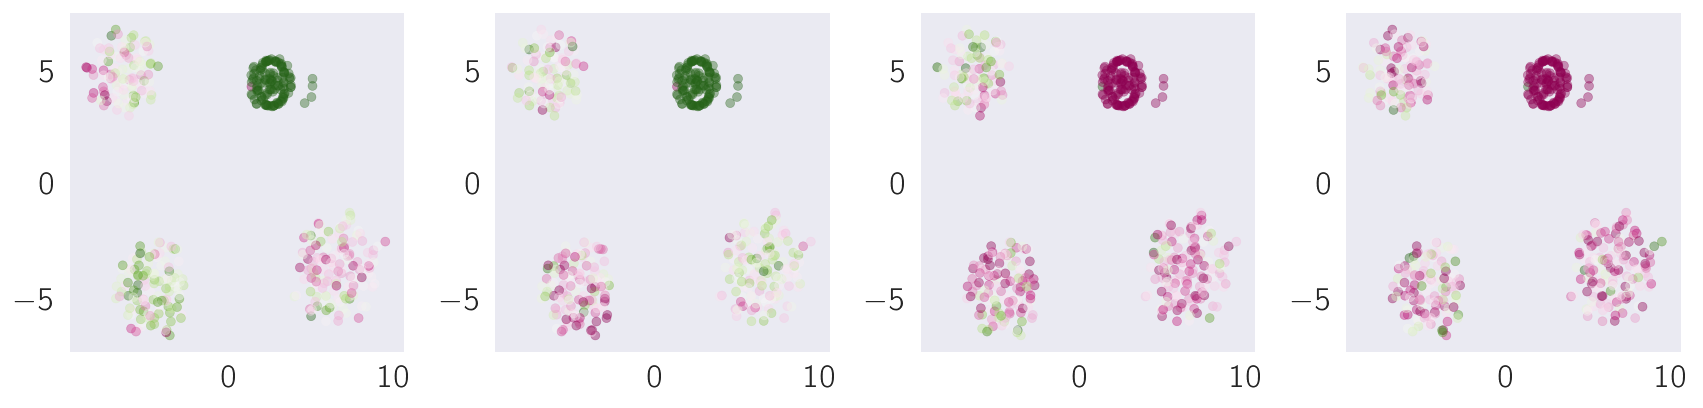

In [100]:
# generate k plots, with each plot colored by  the cluster belonging
fig, ax = plt.subplots(ncols=4, figsize=(12, 3))

for i in np.arange(4):
    # normalize the cluster belonging score so that the lower half is 
    # negative
    color = (W[:, i] - W[:, i].mean())/W[:, i].std()
    plot_clusters(Y, colorV=color, ax=ax[i], s=20, alpha=0.4, cmap='PiYG')

plt.tight_layout()